In [1]:
import os  # noqa
import sys  # noqa

proj_root = os.path.dirname(os.getcwd())
sys.path.append(proj_root)

OBJ_NAME = "mustard_bottle"
VIDEO_NAME = "mustard0"
SUPPORT_GRID = 10
BLACK_BACKGROUND = False
MASK_THRESHOLD = 0.5
NUM_INTERPOLATION_STEPS = 15
# COTRACKER_STEP = 60

video_dir = os.path.join(proj_root, "data", "inputs", VIDEO_NAME)
canonical_points_path = os.path.join(video_dir, "canonical_3d_points.npy")
query_points_path = os.path.join(video_dir, "query_points.npy")
tracker_result_video = os.path.join(video_dir, "tracker_result.mp4")
cam_K_dir = os.path.join(video_dir, "cam_K.txt")
poses_dir = os.path.join(video_dir, "annotated_poses")
video_gt_mask_dir = os.path.join(video_dir, "gt_mask")
video_mask_dir = os.path.join(video_dir, "masks")
video_rgb_dir = os.path.join(video_dir, "rgb")
video_img_dir = os.path.join(video_dir, "img")
video_gt_coords_dir = os.path.join(video_dir, "gt_coords.npy")
video_gt_visibility_dir = os.path.join(video_dir, "gt_visibility.npy")
obj_dir = os.path.join(proj_root, "data", "objects", OBJ_NAME)
obj_path = os.path.join(obj_dir, "textured_simple.obj")
ply_path = os.path.join(obj_dir, "textured.ply")
texture_path = os.path.join(obj_dir, "texture_map.png")

assert BLACK_BACKGROUND != (SUPPORT_GRID is not None), "SUPPORT_GRID must be set if BLACK_BACKGROUND is False"

/home/joao/miniconda3/envs/gspose/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


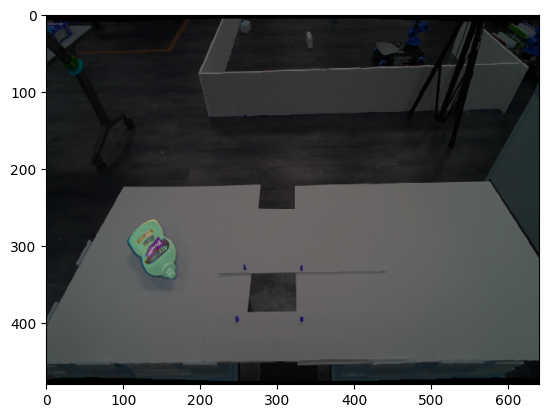

In [2]:
from posingpixels.utils.offscreen_renderer import ModelRendererOffscreen
import cv2
import numpy as np
import trimesh
import matplotlib.pyplot as plt

from posingpixels.utils.meshes import get_diameter_from_mesh
from posingpixels.alignment import get_safe_query_points
import mediapy
from scipy.spatial.transform import Rotation as R
from scipy.spatial.transform import Slerp
from posingpixels.sam import segment
from pathlib import Path
import cv2
import numpy as np
import torch
from concurrent.futures import ThreadPoolExecutor
from cotracker.utils.visualizer import Visualizer
from posingpixels.cotracker import get_online_cotracker_predictions

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


K = np.loadtxt(cam_K_dir).reshape(3, 3)
rgb = cv2.imread(
    os.path.join(video_rgb_dir, "1581120424100262102.png"), cv2.IMREAD_COLOR
)
pose = np.loadtxt(os.path.join(poses_dir, "0000000.txt")).reshape(4, 4)
H, W = rgb.shape[:2]
model_renderer = ModelRendererOffscreen(K, H, W)
mesh: trimesh.Trimesh = trimesh.load_mesh(obj_path)
rgb_render, depth_render = model_renderer.render(mesh, ob_in_cvcam=pose)

overlay = cv2.addWeighted(rgb, 0.5, rgb_render, 0.5, 0)

plt.imshow(overlay)
plt.show()

0.19646325799497472


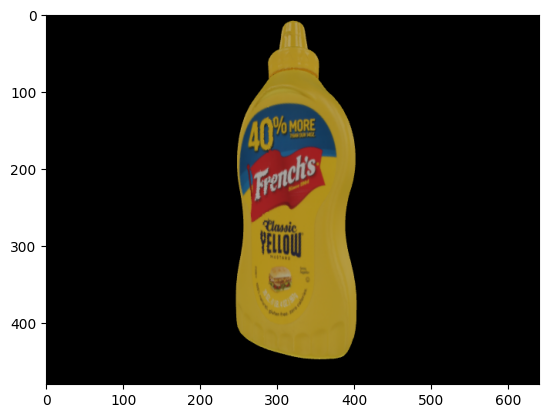

In [3]:
pose_base = np.eye(4)
diameter = get_diameter_from_mesh(mesh)
print(diameter)
# Rotate 90 degrees around x-axis then rotate around y-axis 180 degrees
pose_base[:3, :3] = np.array([[1, 0, 0], [0, 0, -1], [0, 1, 0]])
pose_base[:3, :3] = np.array([[-1, 0, 0], [0, 1, 0], [0, 0, -1]]) @ pose_base[:3, :3]
pose_base[:3, 3] = np.array([0, 0, diameter])
rgb_render, depth_render = model_renderer.render(mesh, ob_in_cvcam=pose_base)

plt.imshow(rgb_render)
plt.show()

In [4]:

if not os.path.exists(video_mask_dir) or len(os.listdir(video_mask_dir)) == 0:
    segment(video_rgb_dir, video_mask_dir, prompts=[(124, 292), (135, 304), (156, 336)])

In [5]:
def sample_support_grid_points(
    H: int, W: int, query_frame_idx: int, query_mask: np.ndarray, grid_size: int = 10
):
    """
    Generates a grid of sample support points within the given frame dimensions,
    excluding the border and avoiding points inside the query mask.

    Args:
        H (int): Height of the frame.
        W (int): Width of the frame.
        query_frame_idx (int): The frame index to which the points belong.
        query_mask (np.ndarray): A binary mask indicating the regions to avoid.
        grid_size (int, optional): The number of grid points along each dimension.
                                   Defaults to 10.

    Returns:
        np.ndarray: An array of shape (N, 3) where N is the number of valid grid points.
                    Each row contains [query_frame, x, y] coordinates of a grid point.
    """
    grid_size += 2
    x = np.linspace(0, W, grid_size, dtype=int)[1:-1]
    y = np.linspace(0, H, grid_size, dtype=int)[1:-1]
    xx, yy = np.meshgrid(x, y)
    pixels = np.stack([xx.flatten(), yy.flatten()], axis=1)
    # Prevent pixels from being inside the query_mask
    pixels = pixels[query_mask[yy.flatten(), xx.flatten()] == 0]
    return np.concatenate(
        [
            query_frame_idx * np.ones((len(pixels), 1)),
            pixels,
        ],
        axis=1,
    )

first_frame_name = sorted(os.listdir(video_rgb_dir))[0]
first_frame = cv2.cvtColor(
    cv2.imread(os.path.join(video_rgb_dir, first_frame_name)),
    cv2.COLOR_BGR2RGB,
)
first_frame_mask = cv2.imread(
    os.path.join(video_mask_dir, "0.png"), cv2.IMREAD_GRAYSCALE
)

unposed_3d_points, query_2d_points = get_safe_query_points(
    R=pose_base[:3, :3],
    T=pose_base[:3, 3],
    camK=K,
    H=H,
    W=W,
    mesh=mesh,
)
num_of_main_queries = len(unposed_3d_points)
# Add support grid
if SUPPORT_GRID is not None:
    support_grid_points = sample_support_grid_points(
        H, W, NUM_INTERPOLATION_STEPS, first_frame_mask, grid_size=SUPPORT_GRID
    )
    query_2d_points = np.concatenate([query_2d_points, support_grid_points], axis=0)

# Save unposed_3d_points and query_2d_points as npy files
np.save(canonical_points_path, unposed_3d_points)
np.save(query_points_path, query_2d_points)
print(query_2d_points.shape)
print(query_2d_points[:5, :])

(170, 3)
[[  0. 321.  37.]
 [  0. 313.  62.]
 [  0. 337.  70.]
 [  0. 304.  86.]
 [  0. 328.  94.]]


In [6]:
def interpolate_poses(R_start, T_start, R_end, T_end, num_steps):
    """Interpolate between initial (R_start, T_start) and final (R_end, T_end) poses using built-in functions."""
    # Convert rotation matrices to `Rotation` objects
    rot_start = R.from_matrix(R_start)
    rot_end = R.from_matrix(R_end)

    # Generate a series of fractional steps from 0 to 1
    fractions = np.linspace(0, 1, num_steps)

    # Interpolate rotation using built-in SLERP
    slerp = Slerp([0, 1], R.from_quat([rot_start.as_quat(), rot_end.as_quat()]))
    rotations = slerp(fractions)

    # Interpolate translation using LERP
    translations = np.array([T_start + f * (T_end - T_start) for f in fractions])

    # Combine rotations and translations into poses
    interpolated_poses = [
        (rotations[i].as_matrix(), translations[i]) for i in range(num_steps)
    ]

    return interpolated_poses


num_steps = NUM_INTERPOLATION_STEPS
interpolated_poses = interpolate_poses(
    pose_base[:3, :3], pose_base[:3, 3], pose[:3, :3], pose[:3, 3], num_steps
)

# Check that video_img_dir exists, if not create it
if not os.path.exists(video_img_dir):
    os.makedirs(video_img_dir)
# Check that video_img_dir is empty, if not delete its contents
for f in os.listdir(video_img_dir):
    os.remove(os.path.join(video_img_dir, f))
# Copy contents from video_rgb_dir (.png) to video_img_dir (.jpg) in order, but renamed with 5-digit numbers
for i, f in enumerate(sorted(os.listdir(video_rgb_dir))):
    img = cv2.imread(os.path.join(video_rgb_dir, f))
    if BLACK_BACKGROUND:
        mask = cv2.imread(os.path.join(video_mask_dir, f"{i}.png"), cv2.IMREAD_GRAYSCALE) / 255
        img[mask < MASK_THRESHOLD, :] = 0
    cv2.imwrite(os.path.join(video_img_dir, f"{i + num_steps:05d}.jpg"), img)
print(np.min(first_frame_mask), np.max(first_frame_mask))
first_frame[first_frame_mask > 0, :] = 0
# Print results
frames = []
# subprocess.run(["ffmpeg", "-i", object_video_path, "-q:v", "2", "-start_number", "0", f"{object_video_dir}/img/%05d.jpg"])
for i, (R_i, T_i) in enumerate(interpolated_poses):
    frame_pose = np.eye(4)
    frame_pose[:3, :3] = R_i
    frame_pose[:3, 3] = T_i
    rgb_render, depth_render = model_renderer.render(mesh, ob_in_cvcam=frame_pose)
    if SUPPORT_GRID is not None:
        depth_render = depth_render[:, :, None]
        rgb_render = first_frame * (depth_render <= 0) + rgb_render * (
            depth_render >= 0
        )
    frames.append(rgb_render)
    cv2.imwrite(
        os.path.join(video_img_dir, f"{i:05d}.jpg"),
        cv2.cvtColor(rgb_render, cv2.COLOR_RGB2BGR),
    )

mediapy.show_video(frames, fps=15)

0 254


In [7]:
pred_tracks, pred_visibility, pred_confidence = get_online_cotracker_predictions(
    video_img_dir,
    grid_size=0,
    queries=query_2d_points,
)

Processing batches: 94it [00:25,  3.73it/s]                        


In [8]:
# Collect and sort filenames
video_files = sorted(Path(video_img_dir).glob("*.jpg"))


# Function to read an image
def read_image(file_path):
    return cv2.cvtColor(cv2.imread(str(file_path)), cv2.COLOR_BGR2RGB)


# Parallel reading
with ThreadPoolExecutor() as executor:
    images = list(executor.map(read_image, video_files))

# Convert to a NumPy array
video_np = np.stack(images, axis=0)

# Convert to PyTorch tensor
video = torch.from_numpy(video_np).to(dtype=torch.uint8)

In [9]:
tracker_result_video = os.path.join(video_dir)
num_of_main_queries = len(unposed_3d_points)
print(num_of_main_queries, pred_tracks.shape, pred_visibility.shape)
print(video.shape)
def visualize_results(video, pred_tracks, pred_visibility, pred_confidence, save_dir, num_of_main_queries = None, filename="video"):
    if num_of_main_queries is None:
        num_of_main_queries = pred_tracks.shape[2]
    vis = Visualizer(save_dir=save_dir, pad_value=0, linewidth=3)
    vis.visualize(
        video.permute(0, 3, 1, 2).unsqueeze(0),
        pred_tracks[:, :, :num_of_main_queries, :],
        (pred_visibility * pred_confidence > 0.6)[:, :, :num_of_main_queries],
        filename=filename,
    )

visualize_results(video, pred_tracks, pred_visibility, pred_confidence, tracker_result_video, num_of_main_queries=num_of_main_queries)

71 torch.Size([1, 752, 170, 2]) torch.Size([1, 752, 170])
torch.Size([752, 480, 640, 3])
Video saved to /home/joao/Documents/repositories/GSPose/data/inputs/mustard0/video.mp4


In [ ]:
# Generate ground truth for the coords location (& visibility)
from typing import Tuple

from posingpixels.utils.geometry import apply_pose_to_points, render_points_in_2d
from tqdm import tqdm

def get_ground_truths(R, T, K, H, W, mesh, unposed_3d_points, prob_mask) -> Tuple[np.ndarray, np.ndarray]:
    model_renderer = ModelRendererOffscreen(K, H, W)
    pose = np.eye(4)
    pose[:3, :3] = R
    pose[:3, 3] = T
    _, depth = model_renderer.render(mesh, ob_in_cvcam=pose)
    posed_3d_points = apply_pose_to_points(unposed_3d_points, R, T)
    gt_coords = render_points_in_2d(posed_3d_points, K[:3, :3])
    # Get the depth values posed_3d_points[:, 2] at the 2D coordinates gt_coords
    gt_depth = depth[gt_coords[:, 1].astype(int), gt_coords[:, 0].astype(int)]
    # Calculate visibility based on depth values
    gt_visibility = (gt_depth - posed_3d_points[:, 2]) > 0.01
    # Apply prob_mask
    gt_visibility = gt_visibility * prob_mask[gt_coords[:, 1].astype(int), gt_coords[:, 0].astype(int)]

    return gt_coords, gt_visibility


gt_coords = np.zeros((len(video_files), num_of_main_queries, 2))
gt_visibility = np.zeros((len(video_files), num_of_main_queries))

for i, (R_i, T_i) in enumerate(tqdm(interpolated_poses, desc="Processing interpolated poses")):
    mask = cv2.imread(os.path.join(video_mask_dir, f"{i}.png"), cv2.IMREAD_GRAYSCALE) / 255
    gt_coords[i], gt_visibility[i] = get_ground_truths(R_i, T_i, K, H, W, mesh, unposed_3d_points, first_frame_mask)

for i in tqdm(range(NUM_INTERPOLATION_STEPS, len(video_files)), desc="Processing remaining frames"):
    mask = cv2.imread(os.path.join(video_mask_dir, f"{i}.png"), cv2.IMREAD_GRAYSCALE) / 255
    pose_path = os.path.join(poses_dir, f"{i - NUM_INTERPOLATION_STEPS:07d}.txt")
    if os.path.exists(pose_path):   
        pose = np.loadtxt(os.path.join(poses_dir, f"{i - NUM_INTERPOLATION_STEPS:07d}.txt")).reshape(4, 4)
    gt_coords[i], gt_visibility[i] = get_ground_truths(pose[:3, :3], pose[:3, 3], K, H, W, mesh, unposed_3d_points, mask)
    
np.save(video_gt_coords_dir, gt_coords)
np.save(video_gt_visibility_dir, gt_visibility)

gt_coords_torch = torch.tensor(gt_coords).to(device)[None]
gt_visibility_torch = torch.tensor(gt_visibility).to(device)[None]
visualize_results(video, gt_coords_torch, gt_visibility_torch, torch.ones_like(gt_visibility_torch).to(device)[None], tracker_result_video, num_of_main_queries=num_of_main_queries, filename="gt_video")

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [ ]:
# See distribution of confidence values over time
conf_np = pred_confidence.detach().cpu().numpy()[0]
print(conf_np.shape)
plt.plot(conf_np.mean(axis=1))
plt.axvline(x=NUM_INTERPOLATION_STEPS - 1, color="r", linestyle="--")
plt.title("Mean confidence over time")
plt.show()
plt.plot(conf_np.mean(axis=1)[:20])
# Plot vertical line at NUM_INTERPOLATION_STEPS
plt.axvline(x=NUM_INTERPOLATION_STEPS -1, color="r", linestyle="--")
plt.title("Mean confidence over time")
plt.show()
# Plot distribution of confidence values at frame NUM_INTERPOLATION_STEPS - 1
plt.hist(conf_np[NUM_INTERPOLATION_STEPS - 1])
plt.title(f"Distribution of confidence values at frame {NUM_INTERPOLATION_STEPS - 1}")
plt.show()
# Plot distribution of confidence values at frame NUM_INTERPOLATION_STEPS + 1
plt.hist(conf_np[NUM_INTERPOLATION_STEPS + 1])
plt.title(f"Distribution of confidence values at frame {NUM_INTERPOLATION_STEPS + 1}")
plt.show()